# Part 2, Question 2 - Build a sentiment analysis model on [movie reviews](www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis)

## Task

- Text Normalisation: Clean and normalise the text by removing noise,
punctuation, and special characters. Also, handle common text
normalisation tasks such as lowercasing, stemming, and
lemmatization.
- Utilise a pre-trained NER model or train your own using an appropriate
dataset. Extract named entities from the text. Print or display the
identified named entities along with their types (e.g., PERSON,
LOCATION, ORGANIZATION).
- Build a naïve bayes classifier and use BOW and feature selection
methods such as selection of the 3000 most important words. You
should evaluate your model on 10 percent of the data, please report
the precision, recall, accuracy, and F-score of each class.
- Preprocess the dataset, tokenize the text, and convert it into a
sequence of word embeddings (such as Word2Vec or GloVe). Design a
BiLSTM classification model and train the model using the labelled
dataset. Evaluate the model's performance on 10 percent of data using
appropriate evaluation metrics and discuss any techniques used to
handle overfitting.
- Compare the results and performance of the two designed classifiers.

## Execution
This notebook is comprised of four sections detailed below. Each section will be marked by a header with the title. Section 4 will contain the title as well as a discussion of the results that are presented in the reports/charts printed. Information on the steps taken and processes performed in sections 1-3 are described below. 

## Section 1 - Text Normalization
The file containing movie reviews is transformed into a dataframe. Steps are taken to normalize the text by lowercasing, removing punctuation, removing numbers, tokenizing the words, and lemmatizing the tokens. There are some cases in which it may be beneficial to not remove numbers, but it was decided to remove them in this case as a visual inspection of the data showed that there were more cases in which numbers may add unecessary noise rather than provide meaningful information. This decision helps in simplifying the data, reducing potential overfitting, and focusing on the textual content, which is likely to be more relevant for the model's performance in this particular context

This section also contains a list of named entities that were extracted from the text using the English language model from spaCy. Only the first 100 words were processed as more took significant time. 

## Section 2 - Naïve Bayes Classifier with Bag-of-Words Vectorizer
This section contains the first of two models evaluated in this notebook. The first one uses the Bag-of-Words vectorizer along with a Naïve Bayes classifier and utilizes feature selection of the 3000 most important words. The data is run through the vectorizer and then the top 3000 keywords are selected and stored in a variable to use in training and testing the model. A Multinomial Naïve Bayes model is then initiated. The model is trained on the cleaned/normalized dataset and makes predictions on the training and test data, which are evaluated and discussed in section 4

## Section 3 - BiLSTM Neural Network with GloVe Vectorizer
This section contains the second model evaluated as to compare a neural network to a traditional classifier. First the GloVe embeddings are loaded using the local file and are used to create the embedding matrix. Then the length is set at 128 and max features at 3000 to match the classifier model, after which the sequences are tokenized and padded to be of uniform length. The embedding matrix is then used to initialize the embedding layer of the BiLSTM model. The BiLSTM model is created and combined with spatial dropout and global max pooling layers. A final sigmoid activation layer makes the model suitable for binary classification tasks. The model is compiled with the Adam optimizer and binary cross-entropy loss, and is trained using early stopping to prevent overfitting by monitoring the validation loss. The model is trained on the cleaned/normalized dataset and makes predictions on the training and test data, which are evaluated and discussed in section 4

## Section 4 - Results and Discussion
This section contains the results of both models and a discussion comparing the performance of each. The results include a classification report and confusion matrix for both models for both the training and testing data. 

In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
import spacy
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

## Section 1 - Text Normalization

In [2]:
file = 'movie.csv'
df = pd.read_csv(file) #create initial df
display(df)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [3]:
lemmatizer = WordNetLemmatizer()

#function to clean and normalize text
def clean_text(text):
    #remove urls
    text = re.sub(r'\[http[s]?://\S+\]', '', text)
    #lowercase the text
    text = text.lower()
    #remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    #remove numbers
    text = re.sub(r'\d+', '', text)
    #tokenize the text
    tokens = word_tokenize(text)
    #lemmatize the tokens
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    #join tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

In [18]:
# Apply the clean_text function to the 'text' column
df['cleaned_text'] = df['text'].apply(clean_text)

display(df[['cleaned_text', 'text']])

,cleaned_text,text
0,i grew up b watching and loving the thunderbir...,I grew up (b. 1965) watching and loving the Th...
1,when i put this movie in my dvd player and sat...,"When I put this movie in my DVD player, and sa..."
2,why do people who do not know what a particula...,Why do people who do not know what a particula...
3,even though i have great interest in biblical ...,Even though I have great interest in Biblical ...
4,im a die hard dad army fan and nothing will ev...,Im a die hard Dads Army fan and nothing will e...
...,...,...
39995,western union is something of a forgotten clas...,"""Western Union"" is something of a forgotten cl..."
39996,this movie is an incredible piece of work it e...,This movie is an incredible piece of work. It ...
39997,my wife and i watched this movie because we pl...,My wife and I watched this movie because we pl...
39998,when i first watched flatliners i wa amazed it...,"When I first watched Flatliners, I was amazed...."


In [5]:
#load English language model from spaCy
sp = spacy.load('en_core_web_sm')

#function to print named entities in the text
def print_entities(text):
    doc = sp(text)
    for ent in doc.ents:
        display(f'{ent.text} - {ent.label_}')

#apply function to the first 100 rows of the 'cleaned_text' column in df 
#only first 100 because it takes very long to process the entire document
df['cleaned_text'].head(100).apply(print_entities)

'early saturday - TIME'

'morning - TIME'

'one - CARDINAL'

'gerry anderson - PERSON'

'jonatha - ORG'

'first - ORDINAL'

'atlantis - PRODUCT'

'first - ORDINAL'

'first - ORDINAL'

'mentionedbr br - PERSON'

'first - ORDINAL'

'atlantis - PRODUCT'

'first - ORDINAL'

'three - CARDINAL'

'first - ORDINAL'

'apollo - ORG'

'one - CARDINAL'

'diane lane - PERSON'

'every minute - TIME'

'abraham - PERSON'

'br br the film - PERSON'

'the early year - DATE'

'sunday afternoon - TIME'

'br br two draw back - PERSON'

'one - CARDINAL'

'german - NORP'

'german - NORP'

'two - CARDINAL'

'janet davis - PERSON'

'janet davis - PERSON'

'scott mcnealy - PERSON'

'sun logo mcnealy - ORG'

'microsoft - ORG'

'scott mcnealy - PERSON'

'last night - TIME'

'mindfker - PERSON'

'gore - PERSON'

'japanese - NORP'

'japanese - NORP'

'asian - NORP'

'japanese - NORP'

'korean - NORP'

'john woos - PERSON'

'hong kong - GPE'

'tampopo - GPE'

'two - CARDINAL'

'steven okazaki - PERSON'

'two - CARDINAL'

'brenda aoki - PERSON'

'cbs - ORG'

'bensonhurst - LOC'

'half - CARDINAL'

'autumn - DATE'

'eleven year - DATE'

'mabel cheung - PERSON'

'beijing - GPE'

'anna - LANGUAGE'

'br jenny - PERSON'

'matt - PERSON'

'jenny - PERSON'

'withbr - ORG'

'two - CARDINAL'

'year ago - DATE'

'two - CARDINAL'

'br br - PERSON'

'problemsbr - CARDINAL'

'the late s and early s - DATE'

'chuck - PERSON'

'just one - CARDINAL'

'chuck - PERSON'

'an hour and a half - TIME'

'minute - TIME'

'hour - TIME'

'pembleton - PERSON'

'greg davis - PERSON'

'bryan daly - PERSON'

'the westboro baptist church adding commentary - ORG'

'christianity - NORP'

'a couple of day - DATE'

'the modern day - DATE'

'dick sargent - PERSON'

'don porter - PERSON'

'two - CARDINAL'

'br tom - PERSON'

'william mcnamara - PERSON'

'br braincandy - PERSON'

'four - CARDINAL'

'two - CARDINAL'

'tim burton - PERSON'

'first - ORDINAL'

'burton - PERSON'

'christmas - DATE'

'evening - TIME'

'br meanwhile max - PERSON'

'christopher walken - PERSON'

'gotham city - PERSON'

'selina kyle michelle - PERSON'

'kyle - PERSON'

'michael keaton - PERSON'

'burton - PERSON'

'two - CARDINAL'

'hour - TIME'

'burton - PERSON'

'burton - PERSON'

'sam hamm - PERSON'

'burton - PERSON'

'max - PERSON'

'washington - GPE'

'br br sidney - PERSON'

'one - CARDINAL'

'br br br br - PERSON'

'first - ORDINAL'

'kooky - PERSON'

'martian - NORP'

'br br - PERSON'

'tim - PERSON'

'ray walston - PERSON'

'martian - NORP'

'christopher lloyd - PERSON'

'martin - PERSON'

'tim - PERSON'

'ehbr - GPE'

'disney - ORG'

'martin - PERSON'

'tim - PERSON'

'jeff - PERSON'

'lucy - PERSON'

'br paging - PERSON'

'michael eisner - PERSON'

'mickey mouse - PERSON'

'john fante - PERSON'

'last summer - DATE'

'one - CARDINAL'

'first - ORDINAL'

'first - ORDINAL'

'camilla - ORG'

'ralph bakshi - PERSON'

'about three year ago - DATE'

'ralph bakshi - PERSON'

'avoidbr br - PERSON'

'french - NORP'

'belgium - GPE'

'two - CARDINAL'

'two - CARDINAL'

'two - CARDINAL'

'late at night - TIME'

'france - GPE'

'a young year old - DATE'

'julie walter rupert grint - PERSON'

'harry potter series - WORK_OF_ART'

'british - NORP'

'first - ORDINAL'

'samehada otoko - PERSON'

'three - CARDINAL'

'third - ORDINAL'

'seven - CARDINAL'

'one - CARDINAL'

'two - CARDINAL'

'argentinian - NORP'

'first - ORDINAL'

'spanish - NORP'

'james joyce titlebr - PERSON'

'irish - NORP'

'california - GPE'

'robert - PERSON'

'mexican - NORP'

'gil vega - PERSON'

'buff - PERSON'

'kitty carlisle - PERSON'

'michael - PERSON'

'ann sheridan lucy ball beryl wallace - PERSON'

'wanda - GPE'

'dorothy white carl brisson - PERSON'

'two - CARDINAL'

'no le - CARDINAL'

'michael - PERSON'

'jack oakie - PERSON'

'victor mclaglen - PERSON'

'mitch leisen - PERSON'

'paris - GPE'

'australia - GPE'

'the union army - ORG'

'gladys egan - PERSON'

'yankee - NORP'

'gladys egan - PERSON'

'don - PERSON'

'burt reynolds - PERSON'

'chum - GPE'

'a minute - TIME'

'saturday - DATE'

'morning - TIME'

'first - ORDINAL'

'joe pesci - PERSON'

'joe cortese - PERSON'

'new jersey - GPE'

'robert deniro - PERSON'

'jerry bos - PERSON'

'fellini - PERSON'

'br br casanova - PERSON'

'today - DATE'

'br casanova - PERSON'

'three - CARDINAL'

'jane stanton - PERSON'

'two - CARDINAL'

'only one - CARDINAL'

'just the final minute - TIME'

'the final minute - TIME'

'african runner - ORG'

'two - CARDINAL'

'paula - PERSON'

'at least one - CARDINAL'

'br br - PERSON'

'only one - CARDINAL'

'lesbian - NORP'

'penelope - GPE'

'ann miller - PERSON'

'five year - DATE'

'one - CARDINAL'

'mary kay place - PERSON'

'lesbian - NORP'

'the year - DATE'

'first - ORDINAL'

'first - ORDINAL'

'superman ii - WORK_OF_ART'

'michael - PERSON'

'one - CARDINAL'

'the moon sequence - LOC'

'daily - DATE'

'clark - PERSON'

'jackie cooper - PERSON'

'thisbr br battle - PERSON'

'warner - ORG'

'many year - DATE'

'two - CARDINAL'

'kayako - GPE'

'juon - GPE'

'american - NORP'

'amnesia - GPE'

'first - ORDINAL'

'three - CARDINAL'

'saturday - DATE'

'night - TIME'

'richard beckinsale - PERSON'

'half - CARDINAL'

'paul verhoevens - PERSON'

'sharon stone - PERSON'

'three - CARDINAL'

'michael fitz - PERSON'

'english - LANGUAGE'

'lee - PERSON'

'english - NORP'

'fitz - ORG'

'three - CARDINAL'

'one - CARDINAL'

'first - ORDINAL'

'br - PERSON'

'new york - GPE'

'american - NORP'

'kalifornia - GPE'

'second - ORDINAL'

'the th century - DATE'

'wolfgang - PERSON'

'first - ORDINAL'

'one - CARDINAL'

'today - DATE'

'month - DATE'

'month - DATE'

'caribbean - LOC'

'five - CARDINAL'

'second - ORDINAL'

'egyptian - NORP'

'first - ORDINAL'

'bernard herrmann - PERSON'

'peter ustinov - PERSON'

'polish - NORP'

'babylonian - NORP'

'egyptian - NORP'

'rick - PERSON'

'first - ORDINAL'

'last night - TIME'

'first - ORDINAL'

'two - CARDINAL'

'french - NORP'

'alex forrest - PERSON'

'strawberry - PERSON'

'creepy - NORP'

'first - ORDINAL'

'three - CARDINAL'

'simon pegg peter serafinowicz - PERSON'

'graham linehan - PERSON'

'arthur matthew - PERSON'

'two - CARDINAL'

'paul steiner - PERSON'

'haliday - DATE'

'pat hill - PERSON'

'chris mitchell ronald allen - PERSON'

'br br - PERSON'

'dutch - NORP'

'lembach gordon heinz - PERSON'

'sheila tracey - PERSON'

'br br - PERSON'

'latham derrick de marney - PERSON'

'bos dr blanchard norman - PERSON'

'br br - PERSON'

'anjelica huston - PERSON'

'robert loggia br br the - PERSON'

'eighty - CARDINAL'

'greek - NORP'

'boyer - PERSON'

'one - CARDINAL'

'dan seymour - PERSON'

'japanese - NORP'

'kong - PERSON'

'the previous december - DATE'

'friday - DATE'

'night - TIME'

'abc - ORG'

'the week - DATE'

'japanese - NORP'

'american - NORP'

'joan van ark - PERSON'

'steven keats - PERSON'

'arctic - LOC'

'nancy wilson - PERSON'

'japan - GPE'

'japan - GPE'

'five - CARDINAL'

'that decade - DATE'

'france - GPE'

'second - ORDINAL'

'today - DATE'

'berton churchill - PERSON'

'one - CARDINAL'

'ben lyon - PERSON'

'raymond hatton - PERSON'

'nora - PERSON'

'james gleason - PERSON'

'henry gordon - PERSON'

'two - CARDINAL'

'robert frazer - PERSON'

'white zombie - FAC'

'king kong - GPE'

'one - CARDINAL'

'moredo - PERSON'

'kevin meyer - PERSON'

'alibi - ORG'

'teri garr - PERSON'

'nick - PERSON'

'nora charles - PERSON'

'kathleen quinlan - PERSON'

'charles martin smith - PERSON'

'bruce mcgill anne ramsey - PERSON'

'estelle harris - PERSON'

'rex linn - PERSON'

'vhs - ORG'

'bbc series - ORG'

'first - ORDINAL'

'british - NORP'

'one - CARDINAL'

'philip stevens - PERSON'

'james stewart - PERSON'

'julie kathleen quinlan - PERSON'

'robert - PERSON'

'two - CARDINAL'

'monte markham wilson - PERSON'

'michael pataki - PERSON'

'over mile - QUANTITY'

'br - PERSON'

'second - ORDINAL'

'jerry jameson - PERSON'

'three - CARDINAL'

'three - CARDINAL'

'odd minute - TIME'

'george kennedy - PERSON'

'joe patroni - PERSON'

'an extra hour - TIME'

'george kennedy - PERSON'

'three hour - TIME'

'two - CARDINAL'

'two - CARDINAL'

'jack lemmon - PERSON'

'james stewart - PERSON'

'one - CARDINAL'

'lee - PERSON'

'christopher lee - PERSON'

'three - CARDINAL'

'the concorde airport - FAC'

'american - NORP'

'american - NORP'

'american - NORP'

'cia - ORG'

'arab - NORP'

'osama bin ladenbr br - PERSON'

'afghan - NORP'

'soviet - NORP'

'american - NORP'

'hoffmam - PERSON'

'american - NORP'

'american - NORP'

'american - NORP'

'american - NORP'

'kennan - GPE'

'ivory wayans - PERSON'

'one - CARDINAL'

'steven seagal - PERSON'

'jim campbell keenan - PERSON'

'jack cole - PERSON'

'one - CARDINAL'

'cia - ORG'

'william - PERSON'

'shoveler - PERSON'

'janeane garofalo - PERSON'

'a couple of year - DATE'

'br br none - PERSON'

'tim healy - PERSON'

'leeds united - PERSON'

'mike - PERSON'

'english - LANGUAGE'

'german - NORP'

'br br - PERSON'

'bostonworth united - ORG'

'first - ORDINAL'

'fifteen - DATE'

'first - ORDINAL'

'fifteen - DATE'

'a night - TIME'

'two - CARDINAL'

'br br rating - PERSON'

'three - CARDINAL'

'four - CARDINAL'

'the middle of the - DATE'

'morning - TIME'

'first - ORDINAL'

'only last maybe minute - TIME'

'second - ORDINAL'

'two - CARDINAL'

'la vega - PERSON'

'third - ORDINAL'

'the night - TIME'

'creepy - NORP'

'glenn quinn - PERSON'

'first - ORDINAL'

'four - CARDINAL'

'fifth - ORDINAL'

'san francisco - GPE'

'rome - GPE'

'macao - GPE'

'new york - GPE'

'a united nation committee - ORG'

'third - ORDINAL'

'don powell - PERSON'

'night - TIME'

'asian - NORP'

'midnight - TIME'

'new york - GPE'

'india - GPE'

'george eastman - PERSON'

'boris karloff - ORG'

'that year ago - DATE'

'africa - LOC'

'dr benetbela - PERSON'

'postworld war ii - EVENT'

'hillyer - PERSON'

'first - ORDINAL'

'one - CARDINAL'

'one - CARDINAL'

'one three - CARDINAL'

'gore - PERSON'

'gore - PERSON'

'charlie sheen - PERSON'

'fbi - ORG'

'one - CARDINAL'

'zero - CARDINAL'

'damien lee - PERSON'

'one - CARDINAL'

'gore - PERSON'

'neil hamilton - PERSON'

'two - CARDINAL'

'spielberg jaw - PERSON'

'gore - PERSON'

'italian - NORP'

'night - TIME'

'john lafia - PERSON'

'br vanessa williams - PERSON'

'next day - DATE'

'dragon ma jackie chanis - PERSON'

'chinese - NORP'

'chinese - NORP'

'first - ORDINAL'

'one - CARDINAL'

'jackie chan - PERSON'

'jackie chan - PERSON'

'today - DATE'

'one - CARDINAL'

'five minute - TIME'

'br br - PERSON'

'first - ORDINAL'

'knight jad capelja - PERSON'

'two - CARDINAL'

'two - CARDINAL'

'danny tony - PERSON'

'weekend - DATE'

'first - ORDINAL'

'these day - DATE'

'sean - NORP'

'william scott - PERSON'

'american - NORP'

'john schneider - PERSON'

'johnny knoxville - PERSON'

'luke duke - PERSON'

'jessica simpson - PERSON'

'jessica simpson - PERSON'

'later at night - TIME'

'a weekend - DATE'

'robert - PERSON'

'first - ORDINAL'

'atlantis - PRODUCT'

'five year ago - DATE'

'one - CARDINAL'

'these day - DATE'

'atlantis - PRODUCT'

'france - GPE'

'ford - ORG'

'french - NORP'

'egyptian - NORP'

'egyptian - NORP'

'juliet - NORP'

'five year - DATE'

'br br - PERSON'

'bbc - ORG'

'year - DATE'

'greek - NORP'

'lefteris papapetrou - PERSON'

'alekos flora - PERSON'

'machi johnnie corrina - PERSON'

'one day - DATE'

'machi machi - PERSON'

'johnny - PERSON'

'the end of the first period - DATE'

'second - ORDINAL'

'greek - NORP'

'greek - NORP'

'first - ORDINAL'

'year old - DATE'

'the other day - DATE'

'today - DATE'

'a little im year old - DATE'

'br charlie - PERSON'

'charlie - PERSON'

'first - ORDINAL'

'watchbr br - PERSON'

'david suchet - PERSON'

'nile - LOC'

'agatha christie novel - ORG'

'david soul - PERSON'

'first - ORDINAL'

'france - GPE'

'my hometown year ago - DATE'

'nine and today - DATE'

'two - CARDINAL'

'today - DATE'

'december - DATE'

'joe kelly - PERSON'

'japanese - NORP'

'kobe - GPE'

'the korean war - EVENT'

'korean - NORP'

'japan - GPE'

'american - NORP'

'japanese - NORP'

'joe kelly - PERSON'

'japanese - NORP'

'war inc corporation - ORG'

'hauser john cusack - PERSON'

'john cusack - PERSON'

'half a dozen - CARDINAL'

'warbr br john cusack - PERSON'

'marisa tomei - PERSON'

'russian - NORP'

'whine - PERSON'

'ben kingsley - PERSON'

'year - DATE'

'dick - PERSON'

'jim carrey - PERSON'

'jim carrey - PERSON'

'forty year old - DATE'

'jim carrey - PERSON'

'jim carrey - PERSON'

'richard jenkins - PERSON'

'aaron michael jenkins - PERSON'

'richard jenkins - PERSON'

'jim carrey - PERSON'

0     None
1     None
2     None
3     None
4     None
      ... 
95    None
96    None
97    None
98    None
99    None
Name: cleaned_text, Length: 100, dtype: object

## Section 2 - Naïve Bayes Classifier with Bag-of-Words Vectorizer

In [6]:
#split data into features and labels
X = df['cleaned_text']
y = df['label']

#split data into training and testing sets
X_train, X_test, y_train_bow, y_test_bow = train_test_split(X, y, test_size=0.1, random_state=42)

#initialize bow vectorizer
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

#top 3000 feature selection
selector = SelectKBest(chi2, k=3000)
X_train_bow_selected = selector.fit_transform(X_train_bow, y_train_bow)
X_test_bow_selected = selector.transform(X_test_bow)

In [7]:
#initiate naive bayes model
nb_classifier = MultinomialNB()

#train model
nb_classifier.fit(X_train_bow_selected, y_train_bow)

#predict on the train and test set
y_pred_train_bow = nb_classifier.predict(X_train_bow_selected)
y_pred_test_bow = nb_classifier.predict(X_test_bow_selected)

## Section 3 - BiLSTM Neural Network with GloVe Vectorizer

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
#load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file_path = 'glove.6B.100d.txt'
embeddings_index = load_glove_embeddings(glove_file_path)

In [10]:
#set max length for sequences to 128 tokens
maxlen = 128

#top 3000 feature selection to match naive bayes model
max_features = 3000  

#tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
word_index = tokenizer.word_index

#ensure all sequences are padded to maxlen
data = pad_sequences(sequences, maxlen=maxlen)

#prepare embedding matrix using GloVe embeddings
embedding_dim = 100
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
#split data into training and testing sets
labels = df['label'].values
X_train_bilstm, X_test_bilstm, y_train_bilstm, y_test_bilstm = train_test_split(data, labels, test_size=0.1, random_state=42)

In [12]:
#define BiLSTM model parameters and layers
inputs = Input(shape=(maxlen,))
x = Embedding(input_dim=embedding_matrix.shape[0], 
              output_dim=embedding_matrix.shape[1], 
              weights=[embedding_matrix], 
              input_length=maxlen, 
              trainable=False)(inputs)
x = SpatialDropout1D(0.2)(x)  #1st dropout layer
bilstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(x)
x = GlobalMaxPooling1D()(bilstm)
x = Dropout(0.5)(x)  #2nd dropout layer
outputs = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

#initialize model
bilstm_model = Model(inputs=inputs, outputs=outputs)

#compile model
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [13]:
#train  model
bilstm_model.fit(X_train_bilstm, y_train_bilstm, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

#predict on train and test sets
y_pred_train_bilstm = (bilstm_model.predict(X_train_bilstm) > 0.5).astype("int32")
y_pred_test_bilstm = (bilstm_model.predict(X_test_bilstm) > 0.5).astype("int32")

Epoch 1/5


2024-07-18 18:34:31.628866: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


900/900 [==============================] - 29s 32ms/step - loss: 0.8306 - accuracy: 0.6484 - val_loss: 0.5759 - val_accuracy: 0.7479
Epoch 2/5
900/900 [==============================] - 28s 31ms/step - loss: 0.5856 - accuracy: 0.7470 - val_loss: 0.5278 - val_accuracy: 0.7901
Epoch 3/5
900/900 [==============================] - 26s 29ms/step - loss: 0.5526 - accuracy: 0.7658 - val_loss: 0.5081 - val_accuracy: 0.7910
Epoch 4/5
900/900 [==============================] - 27s 31ms/step - loss: 0.5301 - accuracy: 0.7793 - val_loss: 0.5025 - val_accuracy: 0.8060
Epoch 5/5
125/125 [==============================] - 1s 11ms/step


## Section 4.1 - Results
Below are results from both models. For each model there is a classification report as well as confusion matrix for test and train data. Below these visualizations is a discussion of the results

In [14]:
import matplotlib.pyplot as plt

In [15]:
#function to print and plot confusion matrix
#normalization can be applied by setting `normalize=True`

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
 

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #format as percentage of total for readability
    fmt = '.2%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


BoW/NB Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1984
           1       0.86      0.82      0.84      2016

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000


BiLSTM Classification Report:
              precision    recall  f1-score   support

     Class 0       0.82      0.77      0.79      1984
     Class 1       0.78      0.84      0.81      2016

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000



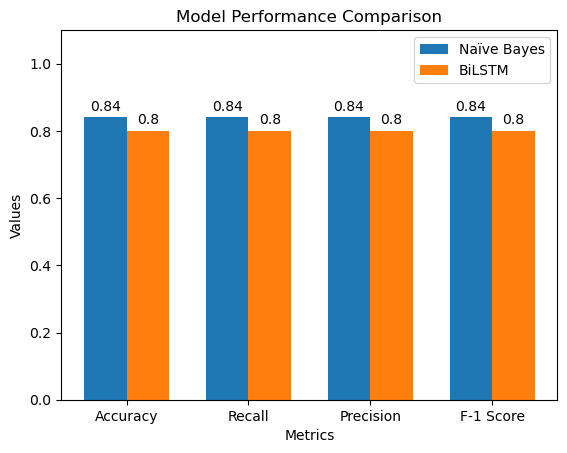

In [19]:
#generate classification reports
print("\nBoW/NB Classification Report:")
print(classification_report(y_test_bow, y_pred_test_bow))
print("\nBiLSTM Classification Report:")
print(classification_report(y_test_bilstm, y_pred_test_bilstm, target_names=['Class 0', 'Class 1']))

metrics = ['Accuracy', 'Recall', 'Precision', 'F-1 Score']
bow_nb_results= [0.84, 0.84, 0.84, 0.84]  
bilstm_results = [0.8, 0.8, 0.8, 0.8]  

x = np.arange(len(metrics))  # the label locations

width = 0.35

fig, ax = plt.subplots()
ax.set_ylim(0, 1.1)
bar1 = ax.bar(x - width/2, bow_nb_results, width, label='Naïve Bayes')
bar2 = ax.bar(x + width/2, bilstm_results, width, label='BiLSTM')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)


plt.show()

/var/folders/xv/sn8jydbd0l9cp5p7d50ry3b80000gn/T/ipykernel_46242/4053889142.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


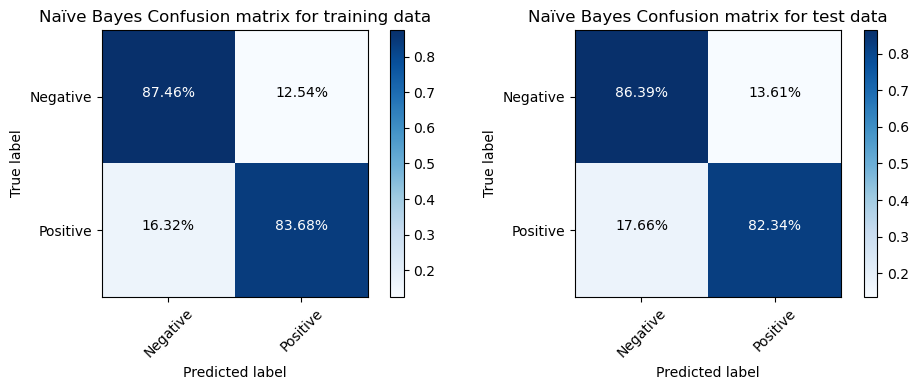

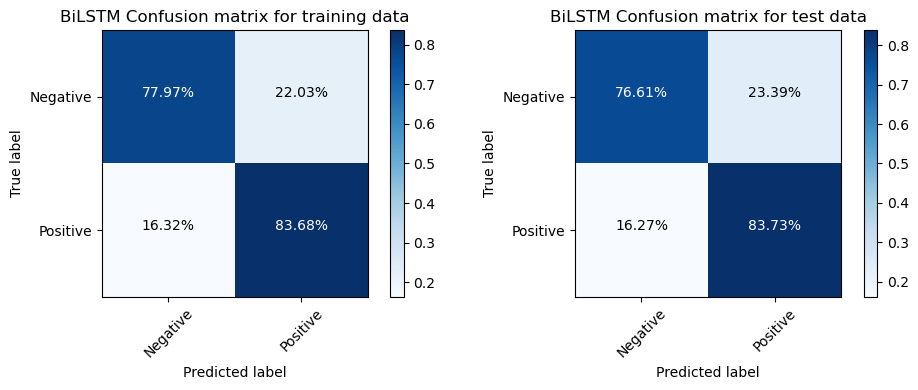

In [20]:
#creating confusion matrix data
cnf_train_matrix_bow = confusion_matrix(y_train_bow, y_pred_train_bow)
cnf_test_matrix_bow = confusion_matrix(y_test_bow, y_pred_test_bow)

cnf_train_matrix_bilstm = confusion_matrix(y_train_bilstm, y_pred_train_bilstm)
cnf_test_matrix_bilstm = confusion_matrix(y_test_bilstm, y_pred_test_bilstm)


#plot BoW confusion matrix
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_confusion_matrix(cnf_train_matrix_bow, classes=["Negative","Positive"],normalize=True,
                      title='Naïve Bayes Confusion matrix for training data')

plt.subplot(122)
plot_confusion_matrix(cnf_test_matrix_bow, classes=["Negative","Positive"],normalize=True,
                      title='Naïve Bayes Confusion matrix for test data')
plt.savefig("nb_confusionmx")
plt.show()

#plot BiLSTM confusion matrix
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_confusion_matrix(cnf_train_matrix_bilstm, classes=["Negative","Positive"],normalize=True,
                      title='BiLSTM Confusion matrix for training data')

plt.subplot(122)
plot_confusion_matrix(cnf_test_matrix_bilstm, classes=["Negative","Positive"],normalize=True,
                      title='BiLSTM Confusion matrix for test data')
plt.savefig("nb_confusionmx")
plt.show()

## Section 4.2 - Discussion

Comparing the BoW/Naïve Bayes(NB), and BiLSTM models for text classification reveals interesting performance differences. The NB model consistently outperforms BiLSTM, with NB achieving the highest overall accuracy (0.84) and showing strong performance in both training and test datasets (up to 87.46% accuracy for negative cases). Simpler models like NB demonstrate stronger immediate classification capabilities, likely due to their straightforward representations and faster training. In contrast, the BiLSTM model shows more balanced performance across metrics but with lower overall accuracy (0.80) and higher misclassification rates. This suggests that while BiLSTM may be better suited for capturing complex patterns in sequential data, it doesn't excel in this particular classification task. The results show the importance of model selection based on specific task requirements, with simpler models often proving highly effective for straightforward classification tasks.

Another reason the BiLSTM may have had worse performance is due to the overfitting prevention techniques that were utilized in the model such as spatial dropout, standard dropout, L2 regularization, and early stopping. These techniques, while crucial for preventing overfitting, have the potential to be applied too aggressively and cause underfitting. As a result, the model could have failed to capture the necessary patterns and nuances in the data. In contrast, the NB model is inherently less complex and doesn't involve such regularization techniques. Therefore it might have been better suited for the dataset in question as its simplicity can allow it to capture the essential features of the data without overfitting or underfitting.

Both the NB and BiLSTM models evaluated here are preliminary versions without further optimization or tuning. To optimize both NB and BiLSTM models, several strategies can be employed. For NB, improving feature engineering through techniques like TF-IDF, n-grams, and stop word removal, as well as fine-tuning hyperparameters, can enhance performance. For BiLSTM, we can increase model complexity, fine tune dropout and regularization to prevent over/underfitting, apply data augmentation techniques, and fine-tune pre-trained embeddings or develop new ones. General strategies applicable to both models also include conducting extensive hyperparameter searches, using cross-validation for generalizability, and implementing ensemble methods.

# References

“All Symbols in TensorFlow 2 | TensorFlow V2.16.1.” TensorFlow, [tensorflow.org/api_docs/python/tf/all_symbols?_gl=1](tensorflow.org/api_docs/python/tf/all_symbols?_gl=1).

“BiLSTM.Config — PyText Documentation.” Pytext.readthedocs.io, [pytext.readthedocs.io/en/master/configs/pytext.models.representations.bilstm.BiLSTM.Config.html](pytext.readthedocs.io/en/master/configs/pytext.models.representations.bilstm.BiLSTM.Config.html). 

“Install SpaCy · SpaCy Usage Documentation.” Install SpaCy, [spacy.io/usage](spacy.io/usage).

“Itertools — Functions Creating Iterators for Efficient Looping — Python 3.9.1 Documentation.” Docs.python.org, [docs.python.org/3/library/itertools.html](docs.python.org/3/library/itertools.html).

Jurafsky, Dan, et al. Speech and Language Processing : An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition. Delhi, Pearson Education, 2008.

“IMDB Movie Ratings Sentiment Analysis.” Www.kaggle.com, www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis.

LDSCI7226 Natural Language Processing with Deep Learning 2023/24 Lecture and Lab Materials

NLTK. “Natural Language Toolkit — NLTK 3.4.4 Documentation.” Nltk.org, 2009, www.nltk.org/.

NumPy. “NumPy Documentation.” Numpy.org, [numpy.org/doc/](numpy.org/doc/).

Pandas. “Pandas Documentation — Pandas 1.0.1 Documentation.” Pandas.pydata.org, 2024, [pandas.pydata.org/docs/](pandas.pydata.org/docs/).

Python. “Re — Regular Expression Operations — Python 3.7.2 Documentation.” Python.org, 2009, [docs.python.org/3/library/re.html](docs.python.org/3/library/re.html).

Scikit-learn. “1.9. Naive Bayes — Scikit-Learn 0.21.3 Documentation.” Scikit-Learn.org, 2019, [scikit-learn.org/stable/modules/naive_bayes.html](scikit-learn.org/stable/modules/naive_bayes.html).

“Sklearn.feature_extraction.text.CountVectorizer — Scikit-Learn 0.20.3 Documentation.” Scikit-Learn.org, 2018, [scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html](scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).